In [1]:
import flexs

In [18]:
import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
import numpy as np
import json

import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils
import torch.nn.functional as F
import torch

In [19]:
from collections import OrderedDict

enc_len = 50
num_actions = 21


char_pairs = [('A', 0), ('R', 1), ('N', 2), ('D', 3), ('C', 4), ('E', 5), ('Q', 6), ('G', 7), ('H', 8), ('I', 9), ('L', 10), ('K', 11), ('M', 12), ('F', 13), ('P', 14), ('S', 15), ('T', 16), ('W', 17), ('Y', 18), ('V', 19), ('>', 20)]
mol_enc = OrderedDict(char_pairs)
enc_mol = OrderedDict(list(map(lambda x : (x[1], x[0]), char_pairs)))

In [20]:
def seq_to_enc(seq):
    enc = [None for i in range(enc_len)]
    for i in range(enc_len):
        if i < len(seq):
            enc[i] = mol_enc[seq[i]]
        else:
            enc[i] = 20
    
    return F.one_hot(torch.tensor(enc), num_classes=num_actions).numpy()

In [21]:
def convertor(sequences):
    """
        Does the padding of the sequences to the correct length... w/ the extra chars...
        
        Input: sequences List[str]
        
        Return: list[ndarray]
    """
    
    all_seqs = []
    for seq in sequences:
        all_seqs.append(seq_to_enc(seq).flatten())
        
    return np.stack(all_seqs)
    
    
    

In [26]:
import pickle

class AMPLandscape(flexs.Landscape):
    """AMP landscape."""

    def __init__(self, mode):
        """Create a AMP landscape."""
        super().__init__(name="AMP")
        assert mode == 'val' or mode == 'test'
        self.alphabet = flexs
        
        if mode == 'val':
            fname = "data/metarlbo_rfc_not-alibicani.pkl"
        elif mode == 'test':
            fname = "data/metarlbo_rfc_alibicani.pkl"
                
        with open(fname, "rb") as f:
            self.model = pickle.load(f)


    def _fitness_function(self, sequences):
        """
            Takes as input a list of strings (w/ alphabet of 20)
            
            
            Returns numpy array of scores
        """
        
        np_seqs = convertor(sequences)
        
        scores = self.model.predict_proba(np_seqs)[:, 1]
        
        return scores
        
        
        
    

In [38]:
landscape = AMPLandscape("test")
alph_chars = list(mol_enc.keys())[:-1]
alphabet=''.join(alph_chars)

In [46]:
bsize = 250

## Random Explorer

In [47]:
rand_seq_len = 30
starting_sequence = "".join([np.random.choice(list(alph_chars)) for _ in range(rand_seq_len)])

cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

random_explorer = baselines.explorers.Random(
    cnn,
    rounds=8,
    mu=1,
    starting_sequence=starting_sequence,
    sequences_batch_size=bsize,
    model_queries_per_batch=bsize,
    alphabet=alphabet
)

In [41]:
random_sequences, metadata = random_explorer.run(landscape)
random_sequences

round: 0, top: 0.075, time: 0.000617s
round: 1, top: 0.175, time: 0.712936s
round: 2, top: 0.185, time: 0.652846s
round: 3, top: 0.185, time: 1.349131s
round: 4, top: 0.185, time: 1.714978s
round: 5, top: 0.21, time: 2.225392s
round: 6, top: 0.28, time: 2.685761s
round: 7, top: 0.28, time: 3.412812s
round: 8, top: 0.28, time: 3.947842s


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,MVESNEYIDSEFPKIAAYIYRGFIVMDYYY,NaN,0.075,0,0,1
0,MKESNEYGDSEFPKIAAYIYQGFIVMDYTY,0.106697,0.100,1,251,251
1,MVESNEYIDSEFPKIAMYIYRGFIVMDYYY,0.100922,0.070,1,251,251
2,MVESNEYIDSEFPKIAAYIYRGFDVMDYYY,0.098670,0.070,1,251,251
3,LVESNEYIDSEFPKIAAYIYRGFIVMDYYY,0.098147,0.070,1,251,251
...,...,...,...,...,...,...
245,MVHSFEYSDSEFPLIEAYIYRGFIVMDYYN,0.100562,0.100,8,2008,2001
246,QVESNEGITSEFPKPAAYIYRGFIVMDRYH,0.099734,0.085,8,2008,2001
247,MREPNEYIDSEFYKIAAKIYRGFIVMLEYY,0.092817,0.085,8,2008,2001
248,MVPSNPYIDCETPKIGAYIYRGFIVMDPYY,0.082896,0.070,8,2008,2001


In [44]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

adalead_explorer = baselines.explorers.Adalead(
    cnn,
    rounds=8,
    starting_sequence=starting_sequence,
    sequences_batch_size=bsize,
    model_queries_per_batch=2000,
    alphabet=alphabet
)

In [45]:
adalead_sequences, metadata = adalead_explorer.run(landscape)

round: 0, top: 0.075, time: 0.000357s
round: 1, top: 0.275, time: 13.208885s
round: 2, top: 0.38, time: 11.158290s
round: 3, top: 0.49, time: 5.648659s
round: 4, top: 0.545, time: 6.849150s
round: 5, top: 0.61, time: 6.687722s
round: 6, top: 0.66, time: 8.526681s
round: 7, top: 0.705, time: 8.499133s
round: 8, top: 0.73, time: 10.799047s


## Genetic Explorer

In [48]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

genetic_explorer = baselines.explorers.GeneticAlgorithm(
    cnn,
    
    population_size=8,
    parent_selection_strategy='wright-fisher', # wright-fisher model decides who gets to 'mate'
    beta=0.01,
    children_proportion=0.2,

    rounds=8,
    starting_sequence=starting_sequence,
    sequences_batch_size=bsize,
    model_queries_per_batch=1000,
    alphabet=alphabet
)

In [49]:
genetic_algo_sequences, metadata = genetic_explorer.run(landscape)

round: 0, top: 0.055, time: 0.000579s
round: 1, top: 0.31, time: 47.479483s


KeyboardInterrupt: 

## CMAES Explorer

In [ ]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

cmaes_explorer = baselines.explorers.CMAES(
    flexs.LandscapeAsModel(landscape),
    
    population_size=10,
    max_iter=200,
    
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=bsize,
    model_queries_per_batch=1000,
    alphabet=alphabet
)

In [ ]:
cmaes_sequences, metadata = cmaes_explorer.run(landscape)

## DynaPPO Explorer

In [50]:
dynappo_explorer = baselines.explorers.DynaPPO(  # DynaPPO has its own default ensemble model, so don't use CNN
    landscape=landscape,
    env_batch_size=10,
    num_model_rounds=10,
    rounds=8,
    starting_sequence=starting_sequence,
    sequences_batch_size=bsize,
    model_queries_per_batch=1000,
    alphabet=alphabet,
)

/Users/leofeng/miniconda3/envs/flexsenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(19))


In [51]:
dynappo_sequences, metadata = dynappo_explorer.run(landscape)

round: 0, top: 0.055, time: 0.000272s
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
round: 1, top: 0.4, time: 34.370612s
round: 2, top: 0.455, time: 45.274750s
round: 3, top: 0.455, time: 53.331195s
round: 4, top: 0.455, time: 73.574244s
round: 5, top: 0.455, time: 84.374833s
round: 6, top: 0.455, time: 88.926061s
round: 7, top: 0.455, time: 101.114303s
round: 8, top: 0.455, time: 113.993819s


# Plots some results

In [53]:

results = {
    'adalead': [0.275, 0.38, 0.49, 0.545, 0.61, 0.66, 0.705, 0.73],
    'dyappo': [0.4, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455],
    'metarlbo': [0.39, 0.41, 0.45, 0.6, 0.73, 0.75, 0.77, 0.77],
    'random_mut': [0.175, 0.185, 0.185, 0.185, 0.21, 0.28, 0.28, 0.28],
}


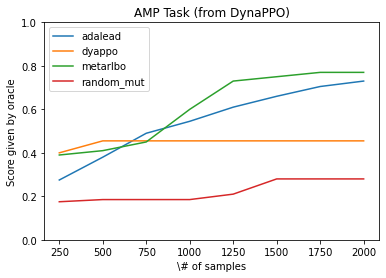

In [57]:
import matplotlib.pyplot as plt

xs = [(i+1)*250 for i in range(8)]


plt.ylim((0, 1))

plt.title("AMP Task (from DynaPPO)")
plt.xlabel("\# of samples")
plt.ylabel("Score given by oracle")


for name, res in results.items():
    plt.plot(xs, res, label=name)
    
plt.legend()